# **Course:** Introduction to Computer Vision (CS231.Q11)

**Topic:** Face Mask Classification

**Member:** 
- Nguyen Cong Phat - 23521143
- Nguyen Le Phong - 23521168
- Vu Viet Cuong - 23520213 

In [1]:
!pip install optuna


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## **1. Imports & config**

In [2]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import local_binary_pattern  # LBP

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import seaborn as sns
from tqdm import tqdm
import joblib


In [ ]:
DATA_DIR = Path("D:/UIT/HK1_25-26/CS231.Q11NhapMonCV/DoAn/Face Mask Dataset")

SPLITS = ["Train", "Validation", "Test"]
CLASSES = ["WithMask", "WithoutMask"]

IMAGE_SIZE = (128, 128)  


LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = "uniform"

def get_lbp_bins(method: str) -> int:
    
    if method == "default":
        return 2 ** LBP_POINTS
    elif method == "ror":
        return LBP_POINTS + 1
    elif method == "uniform":
        return LBP_POINTS + 2
    elif method == "nri_uniform":
        return LBP_POINTS * (LBP_POINTS - 1) + 3
    else:
        raise ValueError(f"Unsupported LBP method: {method}")


CACHE_DIR = Path("cache")
CACHE_DIR.mkdir(exist_ok=True, parents=True)

MODELS_DIR = Path("D:/UIT/HK1_25-26/CS231.Q11NhapMonCV/DoAn/CS231Project/models")
MODELS_DIR.mkdir(exist_ok=True, parents=True)

## **2. Load image paths & basic stats**

In [4]:
def load_split_paths(split: str):
    """
    Trả về list đường dẫn ảnh và nhãn tương ứng
    cho split: Train / Validation / Test
    """
    paths = []
    labels = []
    split_dir = DATA_DIR / split
    for cls in CLASSES:
        class_dir = split_dir / cls
        for img_path in sorted(class_dir.glob("*.*")):
            paths.append(img_path)
            labels.append(cls)
    return np.array(paths), np.array(labels)

all_stats = {}

for split in SPLITS:
    paths, labels = load_split_paths(split)
    unique, counts = np.unique(labels, return_counts=True)
    stats = dict(zip(unique, counts))
    all_stats[split] = stats

all_stats

{'Train': {'WithMask': 5000, 'WithoutMask': 5000},
 'Validation': {'WithMask': 400, 'WithoutMask': 400},
 'Test': {'WithMask': 483, 'WithoutMask': 509}}

## **3. Plot class distribution**

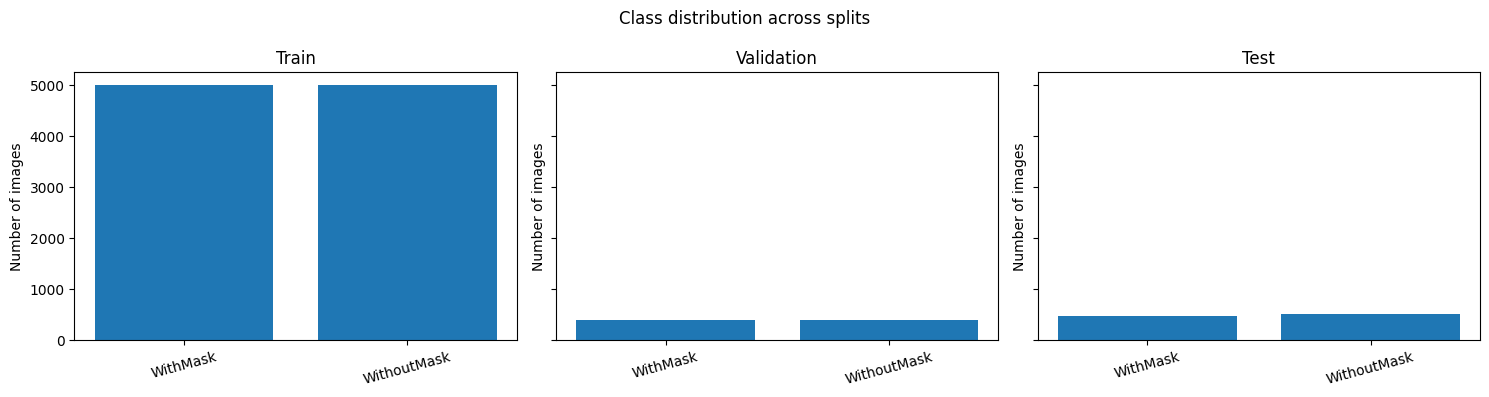

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for i, split in enumerate(SPLITS):
    stats = all_stats[split]
    ax = axes[i]
    ax.bar(list(stats.keys()), list(stats.values()))
    ax.set_title(split)
    ax.set_ylabel("Number of images")
    ax.set_xticks(range(len(stats)))
    ax.set_xticklabels(list(stats.keys()), rotation=15)

plt.suptitle("Class distribution across splits")
plt.tight_layout()
plt.show()

## **4. Show some sample images**

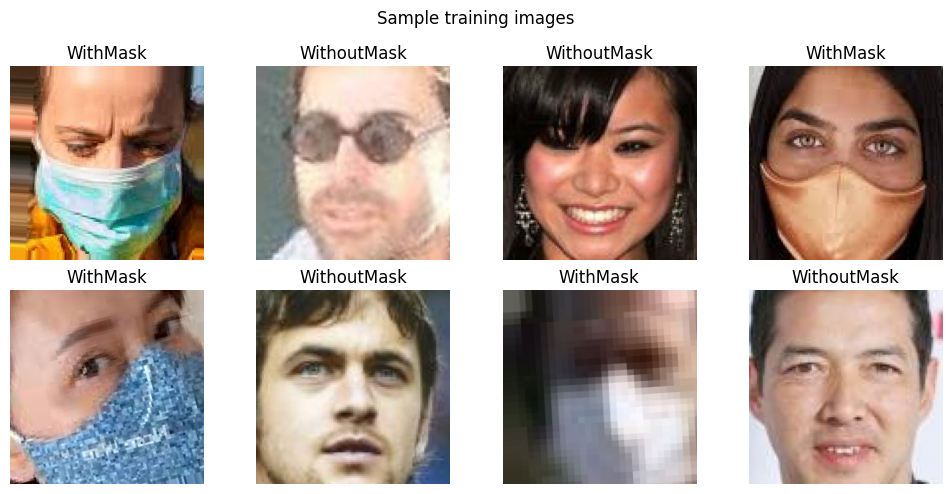

In [6]:
paths_train, labels_train = load_split_paths("Train")

plt.figure(figsize=(10, 5))
idxs = np.random.choice(len(paths_train), size=8, replace=False)
for i, idx in enumerate(idxs, 1):
    img = imread(paths_train[idx])
    plt.subplot(2, 4, i)
    if img.ndim == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.axis("off")
    plt.title(labels_train[idx])
plt.suptitle("Sample training images")
plt.tight_layout()
plt.show()

## **5. COLOR feature extractor (RGB histogram)**

In [7]:
from skimage.feature import local_binary_pattern

def extract_lbp_feature(img_path: Path) -> np.ndarray:
    """
    Trích xuất đặc trưng LBP:
    - Đọc ảnh
    - Chuyển grayscale
    - Resize về IMAGE_SIZE
    - Tính LBP với LBP_POINTS, LBP_RADIUS, LBP_METHOD
    - Tính histogram với số bin = get_lbp_bins(LBP_METHOD), chuẩn hóa L1
    """
    img = imread(img_path)

    # Chuyển về grayscale
    if img.ndim == 3:
        if img.shape[2] == 4:  # RGBA -> RGB
            img = img[..., :3]
        img_gray = rgb2gray(img)
    elif img.ndim == 2:
        img_gray = img
    else:
        raise ValueError(f"Ảnh có shape lạ: {img.shape}")

    # Resize về IMAGE_SIZE
    img_resized = resize(img_gray, IMAGE_SIZE, anti_aliasing=True)
    img_resized = img_resized.astype(np.float32)

    # Tính LBP (theo tham số RF)
    lbp = local_binary_pattern(
        img_resized,
        P=LBP_POINTS,
        R=LBP_RADIUS,
        method=LBP_METHOD
    )

    # Số bin theo hàm get_lbp_bins (y hệt RF)
    n_bins = get_lbp_bins(LBP_METHOD)

    hist, _ = np.histogram(
        lbp.ravel(),
        bins=n_bins,
        range=(0, n_bins)
    )

    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-7)  # giống RF code, tránh chia cho 0

    return hist


# Demo thử trên 1 ảnh
sample_img_path = paths_train[0]
lbp_feat = extract_lbp_feature(sample_img_path)
print("LBP feature length:", lbp_feat.size)  # với radius=1, uniform -> 8*1+2 = 10

LBP feature length: 10


c:\Users\NguyenCongPhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


## **6. Build & cache LBP features**

In [8]:
def get_lbp_features(split: str):
    """
    Tính & cache LBP features cho split: Train / Validation / Test.
    Dùng LBP_POINTS, LBP_RADIUS, LBP_METHOD (giống code RF).
    """
    P = LBP_POINTS
    R = LBP_RADIUS
    cache_file = CACHE_DIR / f"LBP_P{P}_R{R}_{LBP_METHOD}_{split}.npz"

    if cache_file.exists():
        data = np.load(cache_file)
        print(f"[{split}] Loaded LBP from cache")
        return data["X"], data["y"]

    print(f"[{split}] Extracting LBP features...")
    paths, labels = load_split_paths(split)

    feats = []
    for p in tqdm(paths):
        feats.append(extract_lbp_feature(p))   #  chỉ truyền 1 tham số

    X = np.vstack(feats)        # shape: (N, n_bins)
    y = labels
    np.savez_compressed(cache_file, X=X, y=y)
    print(f"[{split}] Saved LBP to cache")
    return X, y


X_train, y_train = get_lbp_features("Train")
X_val,   y_val   = get_lbp_features("Validation")
X_test,  y_test  = get_lbp_features("Test")

X_train.shape, X_val.shape, X_test.shape


[Train] Loaded LBP from cache
[Validation] Loaded LBP from cache
[Test] Loaded LBP from cache


((10000, 10), (800, 10), (992, 10))

c:\Users\NguyenCongPhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


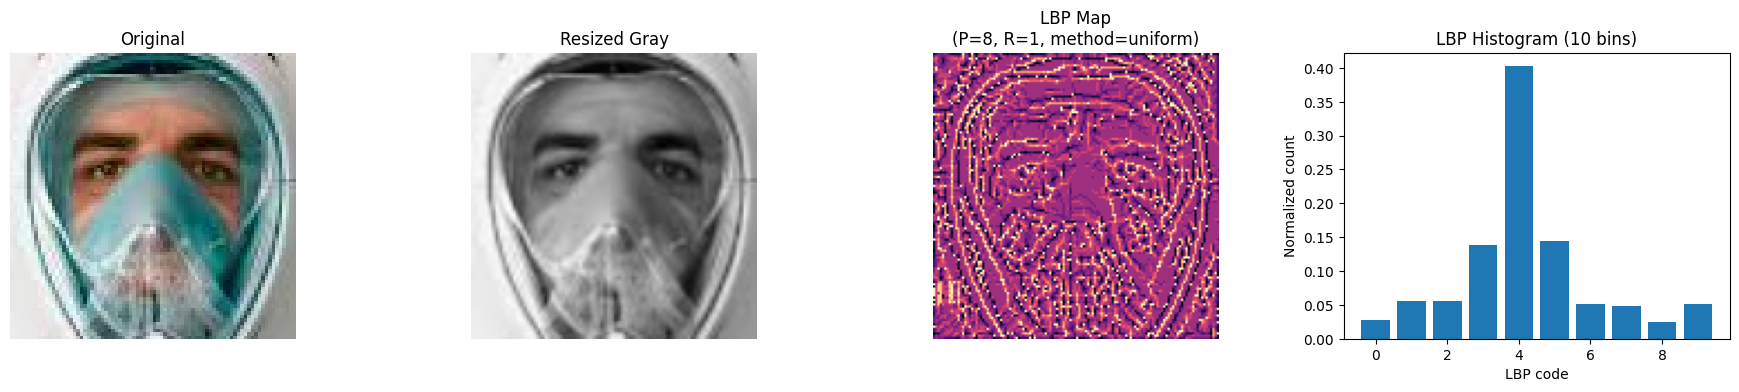

LBP feature length: 10


In [9]:
# --- LBP Visualization Demo ---
from skimage.feature import local_binary_pattern

# Lấy ảnh mẫu
sample_img_path = paths_train[0]
sample_img = imread(sample_img_path)

# Convert grayscale
if sample_img.ndim == 3:
    if sample_img.shape[2] == 4:  # RGBA
        sample_img = sample_img[..., :3]
    sample_gray = rgb2gray(sample_img)
else:
    sample_gray = sample_img

# Resize
sample_resized = resize(sample_gray, IMAGE_SIZE, anti_aliasing=True)

# Compute LBP map
lbp_map = local_binary_pattern(
    sample_resized,
    P=LBP_POINTS,
    R=LBP_RADIUS,
    method=LBP_METHOD
)

# Histogram
n_bins = get_lbp_bins(LBP_METHOD)
hist, _ = np.histogram(lbp_map.ravel(), bins=n_bins, range=(0, n_bins))
hist = hist.astype(np.float32)
hist /= (hist.sum() + 1e-7)


# --- Plot ---
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# 1. Original image
axes[0].imshow(sample_img, cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

# 2. Resized grayscale
axes[1].imshow(sample_resized, cmap="gray")
axes[1].set_title("Resized Gray")
axes[1].axis("off")

# 3. LBP map (visualization)
axes[2].imshow(lbp_map, cmap="magma")   # đẹp nhất để xem texture
axes[2].set_title(f"LBP Map\n(P={LBP_POINTS}, R={LBP_RADIUS}, method={LBP_METHOD})")
axes[2].axis("off")

# 4. Histogram of LBP codes
axes[3].bar(np.arange(n_bins), hist)
axes[3].set_title(f"LBP Histogram ({n_bins} bins)")
axes[3].set_xlabel("LBP code")
axes[3].set_ylabel("Normalized count")

plt.tight_layout()
plt.show()

print("LBP feature length:", hist.size)


## **7. Encode labels**

In [10]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

le.classes_, np.bincount(y_train_enc)


(array(['WithMask', 'WithoutMask'], dtype='<U11'),
 array([5000, 5000], dtype=int64))

## **8. Optuna + KNN (LBP)**

In [11]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

from sklearn.neighbors import KNeighborsClassifier

def objective(trial):
    # Không gian tham số cho KNN
    params = {
        # số láng giềng lẻ để tránh tie
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 31, step=2),
        # uniform: mọi hàng xóm như nhau, distance: gần hơn -> trọng số lớn hơn
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        # p = 1: Manhattan, p = 2: Euclidean
        "p": trial.suggest_int("p", 1, 2),
        # metric để mặc định = "minkowski" (dùng chung với p)
        "metric": "minkowski",
    }

    clf = KNeighborsClassifier(**params)
    clf.fit(X_train, y_train_enc)

    y_val_pred = clf.predict(X_val)
    acc = accuracy_score(y_val_enc, y_val_pred)
    return acc


study_knn = optuna.create_study(
    direction="maximize",
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=1),
    sampler=TPESampler(multivariate=True, seed=42),
)

study_knn.optimize(objective, n_trials=30, n_jobs=1)

print("[LBP-KNN] Best validation accuracy:", study_knn.best_value)
print("[LBP-KNN] Best params:", study_knn.best_params)


c:\Users\NguyenCongPhat\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-30 22:08:41,460] A new study created in memory with name: no-name-b2ba7376-b185-4b07-8404-df7bd70e262c
[I 2025-11-30 22:08:41,737] Trial 0 finished with value: 0.90375 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.90375.
[I 2025-11-30 22:08:41,992] Trial 1 finished with value: 0.905 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.905.
[I 2025-11-30 22:08:42,612] Trial 2 finished with value: 0.90125 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.905.
[I 2025-11-30 22:08:43,036] Trial 3 finished with value: 0.90375 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 1}. Best is tria

[LBP-KNN] Best validation accuracy: 0.92
[LBP-KNN] Best params: {'n_neighbors': 19, 'weights': 'distance', 'p': 1}


## **9. Refit best KNN on Train + Validation**

In [12]:
best_knn_params = study_knn.best_params.copy()

# Gộp Train + Validation để train final model
X_combined = np.vstack([X_train, X_val])
y_combined = np.concatenate([y_train_enc, y_val_enc])

best_knn = KNeighborsClassifier(**best_knn_params)
best_knn.fit(X_combined, y_combined)

print("Done training final LBP-KNN with Optuna best params.")
best_knn_params


Done training final LBP-KNN with Optuna best params.


{'n_neighbors': 19, 'weights': 'distance', 'p': 1}

## **10. Evaluate on Test + confusion matrix + save KNN model**

Test Accuracy (LBP + KNN Optuna): 0.9234

Classification report (KNN + LBP):
              precision    recall  f1-score   support

    WithMask       0.96      0.88      0.92       483
 WithoutMask       0.89      0.96      0.93       509

    accuracy                           0.92       992
   macro avg       0.93      0.92      0.92       992
weighted avg       0.93      0.92      0.92       992



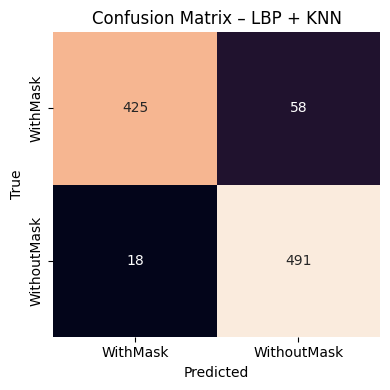

LBP-KNN model saved to: D:\UIT\HK1_25-26\CS231.Q11NhapMonCV\DoAn\CS231Project\models\LBP_KNN_Optuna.joblib


In [13]:
# Dự đoán trên tập Test
y_test_pred_knn = best_knn.predict(X_test)

test_acc_knn = accuracy_score(y_test_enc, y_test_pred_knn)
print(f"Test Accuracy (LBP + KNN Optuna): {test_acc_knn:.4f}\n")

print("Classification report (KNN + LBP):")
print(classification_report(y_test_enc, y_test_pred_knn, target_names=le.classes_))

cm_knn = confusion_matrix(y_test_enc, y_test_pred_knn)

plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_knn,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar=False
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – LBP + KNN")
plt.tight_layout()
plt.show()

# Lưu model + encoder + LBP params
model_path_knn = MODELS_DIR / "LBP_KNN_Optuna.joblib"

joblib.dump(
    {
        "model": best_knn,
        "label_encoder": le,
        "lbp_params": {
            "radius": LBP_RADIUS,
            "points": LBP_POINTS,
            "method": LBP_METHOD,
            "n_bins": get_lbp_bins(LBP_METHOD),
        },
        "image_size": IMAGE_SIZE,
    },
    model_path_knn
)
print("LBP-KNN model saved to:", model_path_knn)
